# Adaptive Exponential IF neuron

Download the Jupyter notebook: [AdEx.ipynb](https://raw.githubusercontent.com/ANNarchy/tutorial/master/src/notebooks/AdEx.ipynb){target="_blank"}

Run it directly on colab: [AdEx.ipynb](https://colab.research.google.com/github/ANNarchy/tutorial/blob/master/src/notebooks/AdEx.ipynb){target="_blank"}

This notebook explores how the AdEx neuron model can reproduce various spiking patterns observed in vivo.

Code based on:

> Naud, R., Marcille, N., Clopath, C., and Gerstner, W. (2008). Firing patterns in the adaptive exponential integrate-and-fire model. Biol Cybern 99, 335. doi:10.1007/s00422-008-0264-7.


On colab:

In [ ]:
!pip install ANNarchy

In [1]:
from ANNarchy import *
clear()
setup(dt=0.1)

ANNarchy 4.7 (4.7.1.5) on darwin (posix).


The AdEx neuron is defined by the following equations:

$$
    C \, \frac{dv}{dt} = -g_L \ (v - E_L) + g_L \, \Delta_T \, \exp(\frac{v - v_T}{\Delta_T}) + I - w
$$

$$
    \tau_w \, \frac{dw}{dt} = a \, (v - E_L) - w
$$

if $v > v_\text{spike}$:

* $v = v_R$
* $w = w + b$

In [2]:
AdEx = Neuron(
    parameters="""
        C = 200.
        gL = 10. # not g_L! g_ is reserved for spike transmission
        E_L = -70.
        v_T = -50.
        delta_T = 2.0
        a = 2.0
        tau_w = 30.
        b = 0.
        v_r = -58.
        I = 500.
        v_spike = 0.0 
    """,
    equations="""
        C * dv/dt = - gL * (v - E_L) +  gL * delta_T * exp((v-v_T)/delta_T) + I - w : init=-70.0     
        tau_w * dw/dt = a * (v - E_L) - w  : init=0.0
    """,
    spike="""
        v >= v_spike
    """,
    reset="""
        v = v_r
        w += b
    """,
    refractory = 2.0
)

We create a population of 8 AdEx neurons which will get different parameter values.

In [3]:
pop = Population(8, AdEx)

In [4]:
compile()

We add a monitor to track the membrane potential and the spike timings during the simulation.

In [5]:
m = Monitor(pop, ['v', 'spike'])

As in the paper, we provide different parameters to each neuron and simulate the network for 500 ms with a fixed input current, and remove that current for an additional 50 ms.

In [6]:
# a) tonic spiking b) adaptation, c) initial burst, d) regular bursting, e) delayed accelerating, f) delayed regular bursting, g) transcient spiking, h) irregular spiking
pop.C =       [200, 200, 130, 200, 200, 200, 100, 100]
pop.gL =      [ 10,  12,  18,  10,  12,  12,  10,  12]
pop.E_L =     [-70, -70, -58, -58, -70, -70, -65, -60]
pop.v_T =     [-50, -50, -50, -50, -50, -50, -50, -50]
pop.delta_T = [  2,   2,   2,   2,   2,   2,   2,   2]
pop.a =       [  2,   2,   4,   2,-10., -6.,-10.,-11.]
pop.tau_w =   [ 30, 300, 150, 120, 300, 300,  90, 130]
pop.b =       [  0,  60, 120, 100,   0,   0,  30,  30]
pop.v_r =     [-58, -58, -50, -46, -58, -58, -47, -48]
pop.I =       [500, 500, 400, 210, 300, 110, 350, 160]

# Reset neuron
pop.v = pop.E_L
pop.w = 0.0

# Simulate
simulate(500.)
pop.I = 0.0
simulate(50.)

# Recordings
data = m.get('v')
spikes = m.get('spike')
for n, t in spikes.items(): # Normalize the spikes
    data[[x - m.times()['v']['start'][0] for x in t], n] = 0.0

We can now visualize the simulations:

/var/folders/6w/6msx49ws7k13cc0bbys0tt4m0000gn/T/ipykernel_72075/1457585605.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 2, i+1)


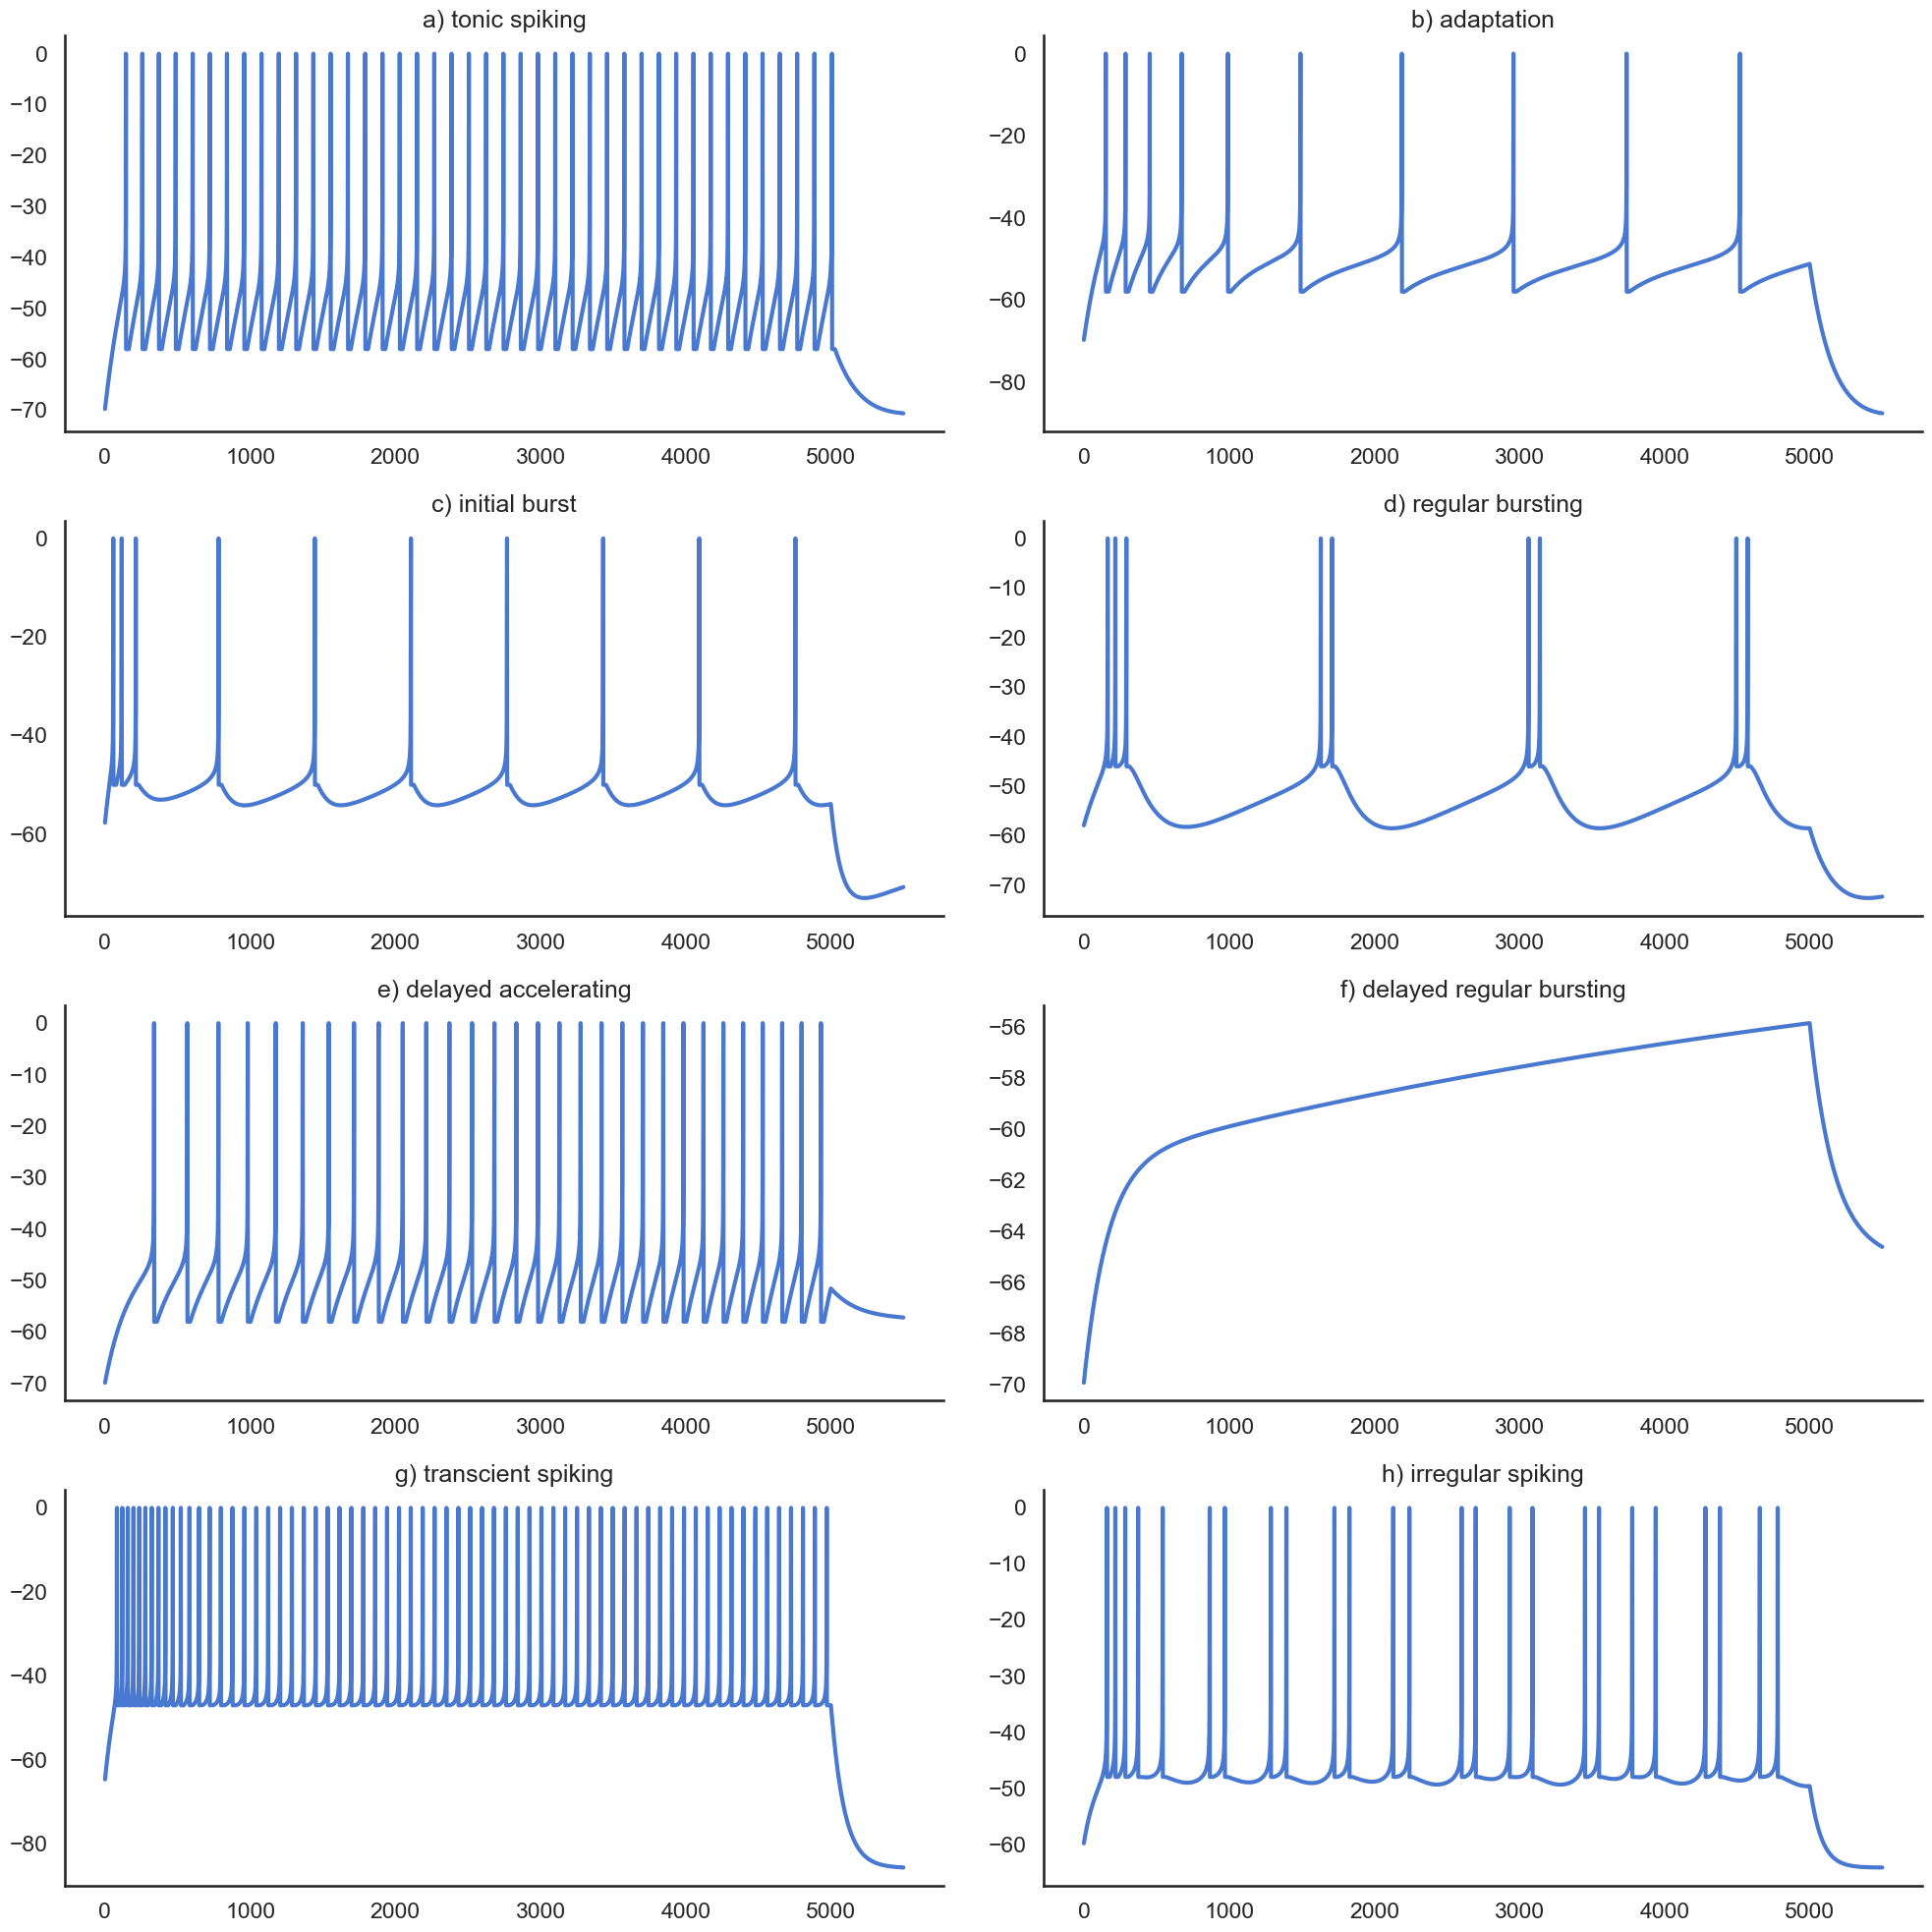

In [7]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("talk")

titles = [
    "a) tonic spiking", 
    "b) adaptation", 
    "c) initial burst", 
    "d) regular bursting", 
    "e) delayed accelerating", 
    "f) delayed regular bursting", 
    "g) transcient spiking", 
    "h) irregular spiking"
]

plt.figure(figsize=(20, 20))
plt.ylim((-70., 0.))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.title(titles[i])
    plt.plot(data[:, i], lw=3)
    

sns.despine()
plt.tight_layout()
plt.show()